<a href="https://colab.research.google.com/github/Arbabyounis46/Project_Breast_Cancer_Classification/blob/main/Breast_Cancer_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Drive to Use Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing The Libraries

In [16]:
# Importing necessary libraries
import os  # For file and directory operations
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis

import tensorflow as tf  # For building and training deep learning models

from sklearn.metrics import *  # For evaluating model performance

import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image augmentation
from tensorflow.keras import layers, models  # For building deep learning models
from tensorflow.keras import regularizers
# Plot evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
# Enable data loading in parallel to improve performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load the CSV file containing information about the data folds
folds_data = pd.read_csv('/content/drive/MyDrive/Data Set/Folds.csv')

# Specify the path where images are stored
images_path = '/content/drive/MyDrive/Data Set/BreaKHis_v1/'

# Define tumor classes for classification
tumor_classes = ['benign', 'malignant']

# The code below this would likely involve data preprocessing, model building, and training.


# Removing the Duplicate Values in the CSV File

In [3]:
# Check for duplicate filenames
duplicate_filename_count = folds_data['filename'].duplicated().sum()
print(f'Number of duplicate filenames: {duplicate_filename_count}')

# Remove duplicate rows based on the 'filename' column to retain only unique entries
folds_data = folds_data.drop_duplicates(subset='filename', keep='first')

# Print the updated shape of the DataFrame
print(f'Updated shape of the DataFrame: {folds_data.shape}')


Number of duplicate filenames: 31636
Updated shape of the DataFrame: (7909, 4)


In [4]:
# Rename the 'filename' column to 'path'
folds_data = folds_data.rename(columns={'filename': 'path'})

# Extract and assign labels from the path (assuming the label is the 4th part of the path)
folds_data['label'] = folds_data['path'].apply(lambda x: x.split('/')[3])

# Convert labels to integer indices based on the defined tumor_classes list
folds_data['label_int'] = folds_data['label'].apply(lambda x: tumor_classes.index(x))

# Extract and assign file names from the path
folds_data['file_name'] = folds_data['path'].apply(lambda x: x.split('/')[-1])

# Update the 'path' column to include the full image folder path
folds_data['path'] = folds_data['path'].apply(lambda x: images_path + x)

# Display the first three rows of the DataFrame to verify the changes
folds_data.head(3)


,fold,mag,grp,path,label,label_int,file_name
0,1,100,train,/content/drive/MyDrive/Data Set/BreaKHis_v1/Br...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,/content/drive/MyDrive/Data Set/BreaKHis_v1/Br...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,/content/drive/MyDrive/Data Set/BreaKHis_v1/Br...,benign,0,SOB_B_A-14-22549AB-100-003.png


Count of Benign    :  2480
Count of Malignant :  5429


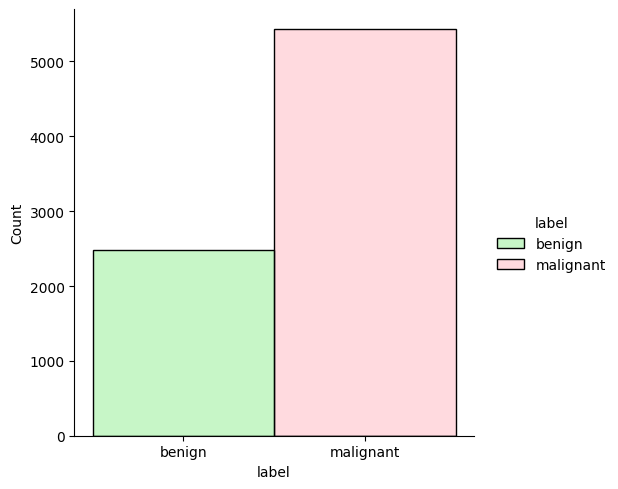

In [5]:
# Defining colors for tumor classes
ax = sns.displot(
    data=folds_data,
    x='label',
    hue='label',
    palette={'benign': 'lightgreen', 'malignant': 'lightpink'}  # Changed colors
)

# Displaying the count of each label
print('Count of Benign    : ', folds_data[folds_data['label'] == 'benign']['label'].count())
print('Count of Malignant : ', folds_data[folds_data['label'] == 'malignant']['label'].count())


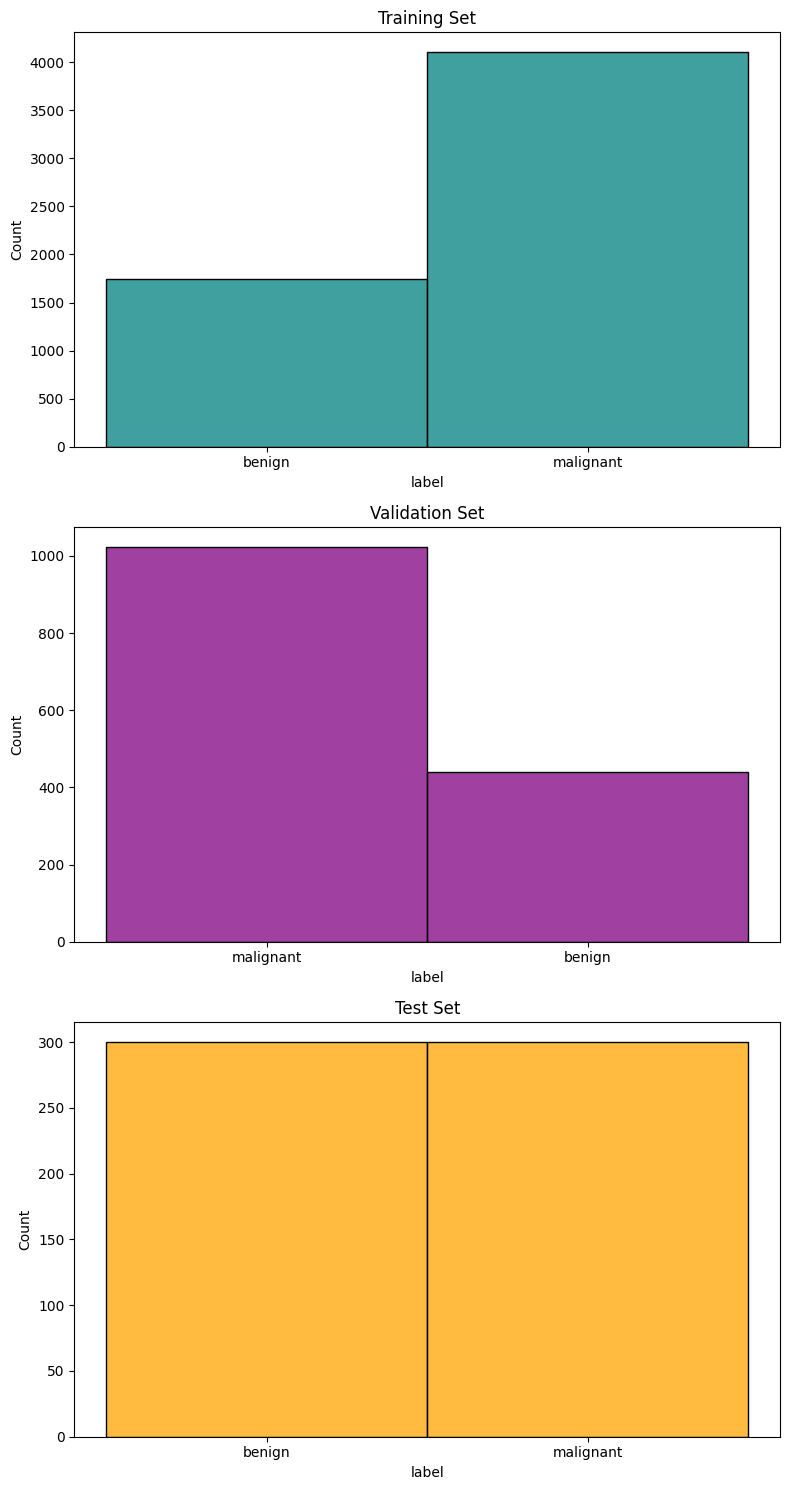

Training set
label
malignant    4106
benign       1741
Name: count, dtype: int64

Validation set
label
malignant    1023
benign        439
Name: count, dtype: int64

Test set
label
benign       300
malignant    300
Name: count, dtype: int64


In [6]:
# Remove 600 samples from the dataset for testing (300 per class)
test_data = folds_data.groupby('label').sample(n=300)
train_data = folds_data.drop(test_data.index).reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Split training and validation sets
validation_data = train_data.sample(frac=0.2)
train_data = train_data.drop(validation_data.index).reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

# Assign set labels and combine data
test_data['set'] = 'test'
train_data['set'] = 'train'
validation_data['set'] = 'valid'
combined_data = pd.concat([train_data, validation_data, test_data])

# Set up the figure with a column of three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# Plot each distribution with different colors and assign to specific axes
sns.histplot(data=train_data, x='label', color='teal', ax=axes[0])
axes[0].set_title('Training Set')

sns.histplot(data=validation_data, x='label', color='purple', ax=axes[1])
axes[1].set_title('Validation Set')

sns.histplot(data=test_data, x='label', color='orange', ax=axes[2])
axes[2].set_title('Test Set')

# Show the plots in a vertical layout
plt.tight_layout()
plt.show()

# Print counts for each set
print('Training set')
print(train_data['label'].value_counts())

print('\nValidation set')
print(validation_data['label'].value_counts())

print('\nTest set')
print(test_data['label'].value_counts())


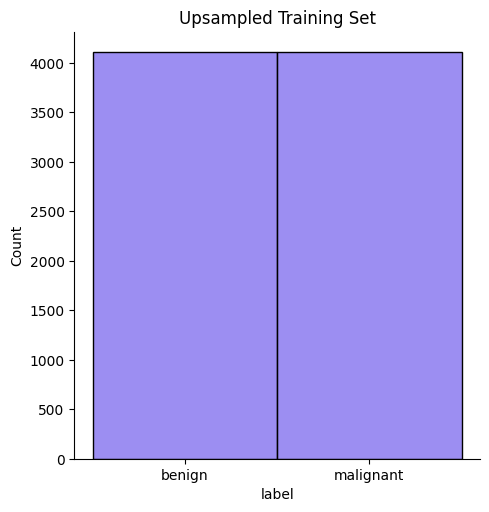

label
benign       4106
malignant    4106
Name: count, dtype: int64


In [7]:
# Upsample the training dataset to balance the classes
max_count = np.max(train_data['label'].value_counts())
train_data = train_data.groupby('label').sample(n=max_count, replace=True).reset_index(drop=True)

# Plot distribution after upsampling
ax = sns.displot(data=train_data, x='label', color='mediumslateblue')
ax.set(title='Upsampled Training Set')
plt.show()

# Display counts to verify upsampling
print(train_data['label'].value_counts())


# Data Augmentation

In [8]:
# Convert 'label_int' to string type for categorical class mode
train_data['label_int'] = train_data['label_int'].astype(str)
validation_data['label_int'] = validation_data['label_int'].astype(str)

# Data augmentation setup with fewer parameters for simplicity
train_image_gen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use a simpler validation generator with rescaling only
validation_image_gen = ImageDataGenerator(rescale=1./255)

# Training data generator setup
train_data_gen = train_image_gen.flow_from_dataframe(
    dataframe=train_data,
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(210, 210),
    batch_size=64,
    class_mode='sparse'
)

# Validation data generator setup
validation_data_gen = validation_image_gen.flow_from_dataframe(
    dataframe=validation_data,
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(210, 210),
    batch_size=64,
    class_mode='sparse'
)


Found 8212 validated image filenames belonging to 2 classes.
Found 1462 validated image filenames belonging to 2 classes.


# Defining the Model Architecture

In [9]:
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(0.001), input_shape=(210, 210, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Fourth convolutional block
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.35))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))  # Output layer for 2 classes

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling Model

In [10]:
# Compile the model with Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary to verify the final architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 208, 208, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 208, 208, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 206, 206, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 103, 103, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 103, 103, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 101, 101, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 101, 101, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 99, 99, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 49, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 49, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 47, 47, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 47, 47, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 20, 20, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,172,642 (27.36 MB)

 Trainable params: 7,170,914 (27.35 MB)

 Non-trainable params: 1,728 (6.75 KB)

# Model Training

In [11]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train the model with callbacks
history = model.fit(
    train_data_gen,
    epochs=30,
    validation_data=validation_data_gen,
    verbose=1,
    callbacks=callbacks
)

# Save the final model if needed
model.save('custom_cnn_model_breast_cancer.h5')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 2510s 18s/step - accuracy: 0.7261 - loss: 1.9934 - val_accuracy: 0.6997 - val_loss: 3.5826 - learning_rate: 0.0010
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.8075 - loss: 1.7000 - val_accuracy: 0.6997 - val_loss: 2.2764 - learning_rate: 0.0010
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8327 - loss: 1.3985 - val_accuracy: 0.6997 - val_loss: 1.6747 - learning_rate: 0.0010
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8694 - loss: 1.1263 - val_accuracy: 0.7004 - val_loss: 2.0325 - learning_rate: 0.0010
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.8943 - loss: 0.9207 - val_accuracy: 0.8673 - val_loss: 0.9024 - learning_rate: 0.0010
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8754 - loss: 0.8342 - val_accuracy: 0.7038 - val_loss: 1.7893 - learning_rate: 0.0010
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9042 - loss: 0.7148
Epoch 

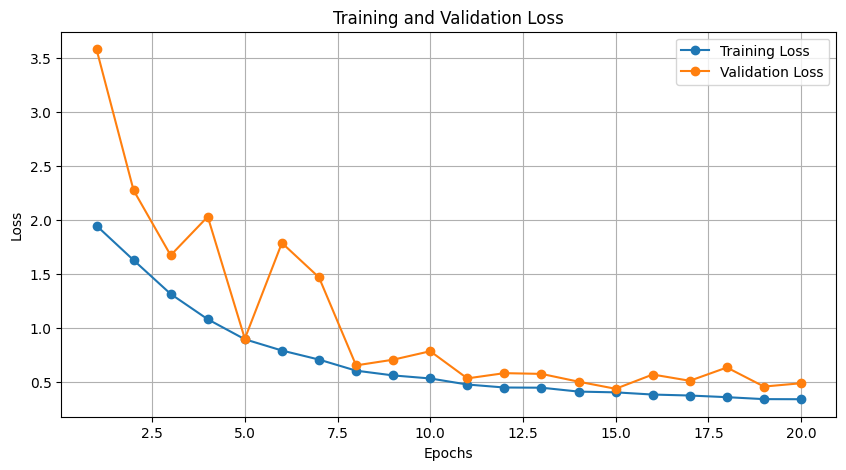

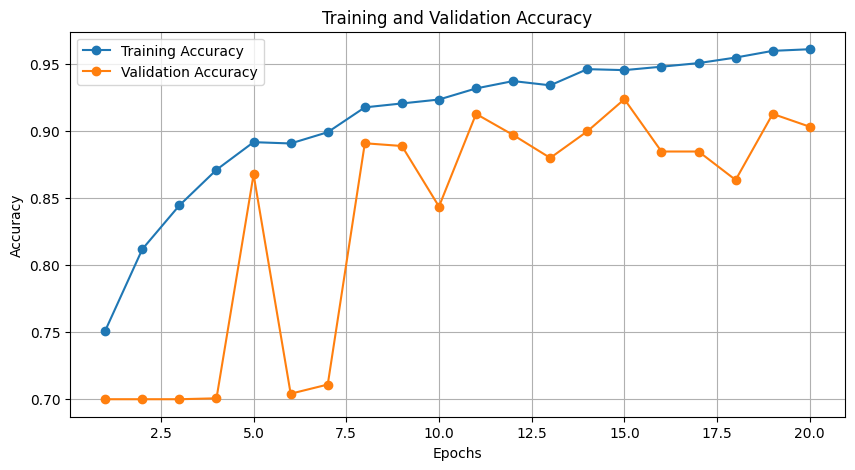

In [12]:
# Extract training history
history_dict = history.history

# Extract metrics
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluating the Model on the Test Set

In [14]:
# Convert 'label_int' to string type for categorical class mode
test_data['label_int'] = test_data['label_int'].astype(str)

# Test data generator setup with rescaling
test_image_gen = ImageDataGenerator(rescale=1./255)

# Create the test data generator
test_generator = test_image_gen.flow_from_dataframe(
    dataframe=test_data,  # Pandas DataFrame with test data
    directory='',        # Directory is empty if paths are absolute
    x_col='path',        # Column with file paths
    y_col='label_int',   # Column with label strings
    target_size=(210, 210),  # Resize images to match model input
    batch_size=64,       # Batch size for the generator
    class_mode='sparse', # Sparse for integer labels (as strings now)
    shuffle=False        # Do not shuffle to keep order for evaluation
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = test_generator.classes               # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names


Found 600 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 207s 23s/step - accuracy: 0.9003 - loss: 0.5281
Test Accuracy: 0.91
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 966ms/step


# Plotting the Evaluation Matrix


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       300
           1       0.89      0.93      0.91       300

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



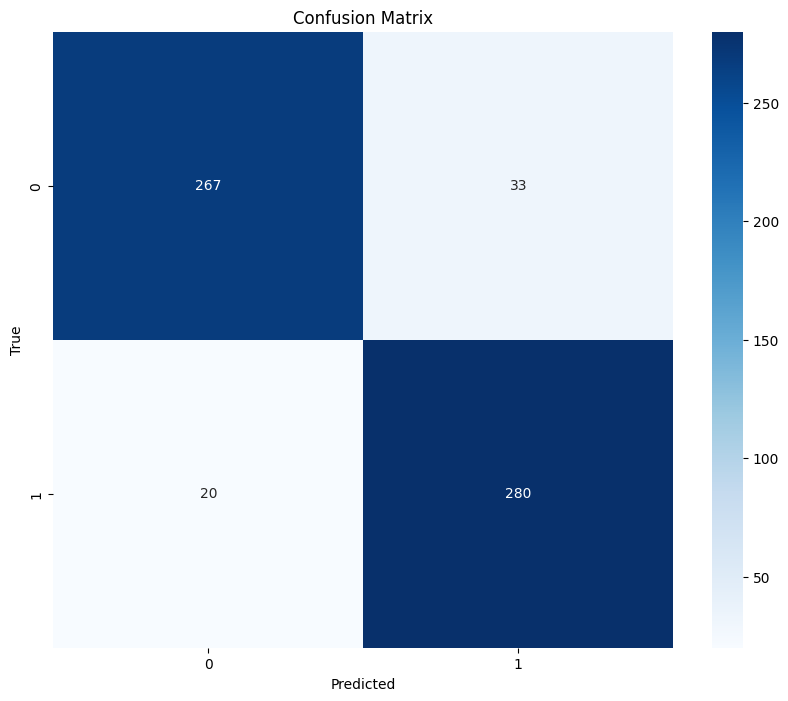

In [15]:
# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# VGG19 Model Training

In [24]:
# Load VGG16 with pretrained weights, excluding the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(210, 210, 3))

# Unfreeze the last two layers of the base model
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Add custom layers on top
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, min_lr=1e-6)]


# Train the model with callbacks
history = model.fit(
    train_data_gen,
    epochs=30,
    validation_data=validation_data_gen,
    verbose=1,
    callbacks=callbacks
)

# Save the final model if needed
model.save('VGG19_model_breast_cancer.h5')

Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.5877 - loss: 1.6750 - val_accuracy: 0.8201 - val_loss: 0.7720 - learning_rate: 0.0010
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.8192 - loss: 0.7174 - val_accuracy: 0.8488 - val_loss: 0.5820 - learning_rate: 0.0010
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8540 - loss: 0.5570 - val_accuracy: 0.8598 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.8722 - loss: 0.4596 - val_accuracy: 0.8502 - val_loss: 0.4968 - learning_rate: 0.0010
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.8778 - loss: 0.4296 - val_accuracy: 0.8611 - val_loss: 0.4613 - learning_rate: 0.0010
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8926 - loss: 0.3663 - val_accuracy: 0.8625 - val_loss: 0.4394 - learning_rate: 0.0010
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.8963 - loss: 0.

In [ ]:
# Extract training history
history_dict = history.history

# Extract metrics
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [23]:
# Convert 'label_int' to string type for categorical class mode
test_data['label_int'] = test_data['label_int'].astype(str)

# Test data generator setup with rescaling
test_image_gen = ImageDataGenerator(rescale=1./255)

# Create the test data generator
test_generator = test_image_gen.flow_from_dataframe(
    dataframe=test_data,  # Pandas DataFrame with test data
    directory='',        # Directory is empty if paths are absolute
    x_col='path',        # Column with file paths
    y_col='label_int',   # Column with label strings
    target_size=(210, 210),  # Resize images to match model input
    batch_size=64,       # Batch size for the generator
    class_mode='sparse', # Sparse for integer labels (as strings now)
    shuffle=False        # Do not shuffle to keep order for evaluation
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = test_generator.classes               # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names


Found 600 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8409 - loss: 0.4023
Test Accuracy: 0.87
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


In [ ]:
# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Resnet50 Model Training